# MCMC for Coin Toss 

<!-- ![gamblimg machine](https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg) -->
<center>
 <img src="https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg" alt="Girl in a jacket" width="80%"> </center>


In [114]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
import tensorflow as tf
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [115]:
bern = tfd.Bernoulli(0.8)

Lets generate samples now.

In [116]:
key = jax.random.PRNGKey(10)
samples = bern.sample(seed = key,sample_shape=10)
samples

DeviceArray([1, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

What am I saying? just sample 2000 points? and then don't visualize it?




Of course not. Lets see the histogram.

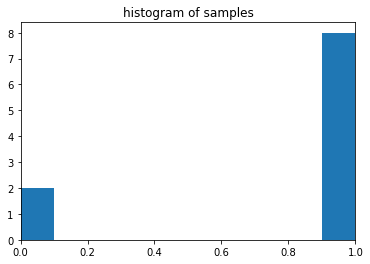

In [117]:
plt.hist(samples)
plt.xlim(0,1)
plt.title("histogram of samples")
plt.show()

Now the fun(trouble) begins!

So we assume the prior here to be a weibull distribution. It has parameters $λ,k$ which signify scale and shape respectively.

The distribution is very dangerous. So lets just see the pdf (which we need) and move on.

\begin{equation}
    f(x;λ,k)=
    \begin{cases}
      \frac{k}{λ}\left(\frac{x}{λ}\right)^ke^{-(x/λ)^k}&,  \text{if}\ x\ge1 \\
      0 &,  \text{if}\ x<0
    \end{cases}
\end{equation}

Lets now look at how pdf varies if we vary the parameters of the funtion.

In [118]:
 
alpha = 10
beta = 15
beta_dist = tfd.Beta(alpha,beta)
@widgets.interact(alpha=(0,20,0.2),beta=(0,20,0.2))
def plot_weibull(alpha=10,beta=15):
  beta_dist = tfd.Beta(alpha,beta)
  x = jnp.linspace(0,1,100)
  beta_pdf = beta_dist.prob(x)
  plt.plot(x,beta_pdf)
  plt.title('Prior PDF')
  plt.xlim(0,1)
#   plt.ylim(0,5)
  # plt.show()

interactive(children=(FloatSlider(value=10.0, description='alpha', max=20.0, step=0.2), FloatSlider(value=15.0…

In [119]:

# lamda = 10.0  --- This was giving some problems. Anyways
def log_postfn(x):
  # from the above equation
  # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
  prob = jax.nn.sigmoid(x)
  log_prior = beta_dist.log_prob(prob)
  # log_likelihood
  berno = tfd.Bernoulli(x)
  log_like = jnp.array([jnp.sum(berno.log_prob(samples))])

  return (log_like+log_prior)[0]

log_postfn(1)


DeviceArray(-9.545955, dtype=float32)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [120]:
rmh = blackjax.rmh(log_postfn, sigma = jnp.array([2]))
m = jnp.array([20.0])
initial_state = rmh.init(m)
initial_state

RMHState(position=DeviceArray([20.], dtype=float32), log_probability=DeviceArray(-inf, dtype=float32))

I don't have a good idea of how the below fn works but it will give us the samples that we need.

In [121]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

Lets generate samples from posterior distribution now.

In [122]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

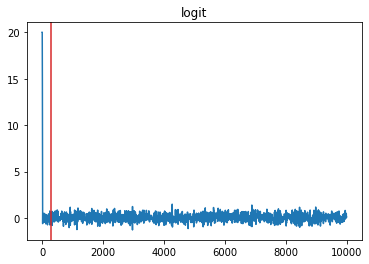

In [123]:
burnin = 300
fig, ax = plt.subplots()
ax.plot(states.position[:,0])
ax.set_title(f"logit")
ax.axvline(x=burnin, c="tab:red")
plt.show()

In [124]:
jnp.sum(samples==1)
one= jnp.sum(samples==1).astype('float32')
zero= jnp.sum(samples==0).astype('float32')

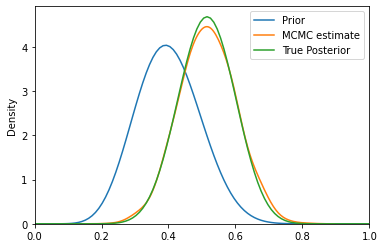

In [125]:
import seaborn as sns
# plt.hist(jax.nn.sigmoid(states.position[300:,0]),density=True,bins=20)
beta_dist = tfd.Beta(alpha,beta)
x = jnp.linspace(0,1,100)
beta_pdf = beta_dist.prob(x)
plt.plot(x,beta_pdf,label="Prior")
sns.kdeplot(jax.nn.sigmoid(states.position[300:,0]),bw_adjust=2,label="MCMC estimate")
beta_dist = tfd.Beta(alpha+one,beta+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")
plt.legend()
plt.xlim(0,1)
plt.show()

In [126]:
 
alpha = 10
beta = 15
beta_dist = tfd.Beta(alpha,beta)
@widgets.interact(alpha=(0,20,0.2),beta=(0,20,0.2))
def plot_weibull(alpha=18,beta=17):
  beta_dist = tfd.Beta(alpha,beta)
  x = jnp.linspace(0,1,100)
  beta_pdf = beta_dist.prob(x)
  plt.plot(x,beta_pdf)
  plt.title('Posterior PDF')
  plt.xlim(0,1)
  plt.ylim(0,5)
  # plt.show()

interactive(children=(FloatSlider(value=18.0, description='alpha', max=20.0, step=0.2), FloatSlider(value=17.0…

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.

<h1> So I am happy :)</h1>